In [1]:
import pandas as pd
import numpy as np
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

# DBSCAN

In [2]:
class DBSCAN:
    def __init__(self, eps=0.3, min_pts=5,batch_size=100,metric='euclidean'):
        self.eps = eps
        self.min_pts = min_pts
        self.metric=metric
        self.batch_size=batch_size
        self.no_of_batches = None
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        # Initialize all the labels with -1 
        self.labels_ = np.full(n_samples, -1) 
        # start with cluster id 0
        cluster_id = 0
        # visited matrix to track visited points
        visited = np.zeros(n_samples, dtype=bool) 
        self.no_of_batches = math.ceil(n_samples/self.batch_size)

        for i in range(n_samples):
            if visited[i]:  
                continue
            visited[i] = True
            neighbors = self.find_neighbors(X, i)
            
            if len(neighbors) < self.min_pts:
                continue  # Noise point
            self.expand_cluster(X, i, neighbors, cluster_id, visited)
            cluster_id += 1

    def find_neighbors(self, X, index):
        
        all_neighbors = []
        for i in range(self.no_of_batches):
            start = i*self.batch_size
            end = min(start + self.batch_size, X.shape[0])
            if self.metric=='cosine':
                distances = cosine_similarity(X=X[index], Y=X[start:end])
                # Get neighbors which are located within the given threshold
                neighbors = [(distances[0][i], start+i) for i in range(len(distances[0])) if distances[0][i] >= self.eps]
            else:
                distances = pairwise_distances(X=[X[index]],Y=X[start:end],metric='euclidean')
                 # Get neighbors which are located within the given threshold
                neighbors = [(distances[0][i], start+i) for i in range(len(distances[0])) if distances[0][i] <= self.eps]
             
            all_neighbors.extend(neighbors) 
       
       
        # Create a priority queue to store distances with index
        
        heapq.heapify(all_neighbors)
        return all_neighbors

    def expand_cluster(self, X, index, neighbors, cluster_id, visited):
        # set label of given index as cluster_id
        self.labels_[index] = cluster_id
        lst_of_neighbors = list(neighbors)  # Convert heap to list
        
        while lst_of_neighbors:
            # Remove the first neighbor
            _, neighbor_index = heapq.heappop(lst_of_neighbors)  # Get closest neighbor
            
            if not visited[neighbor_index]:
                visited[neighbor_index] = True
                new_neighbors = self.find_neighbors(X, neighbor_index)
                if len(new_neighbors) >= self.min_pts:
                    lst_of_neighbors.extend(new_neighbors)  # Add new neighbors
            
            if self.labels_[neighbor_index] == -1:
                self.labels_[neighbor_index] = cluster_id  # Assign cluster

### Load datasets

In [3]:
file1='HW_2B_Data/blobs.csv'
file2='HW_2B_Data/circle.csv'
file3='HW_2B_Data/moons.csv'
file4='HW_2B_Data/dbscan.csv'

In [4]:
df1 = pd.read_csv(file4)
df2 = pd.read_csv(file3)
df3 =pd.read_csv(file2)
df4 = pd.read_csv(file1)

### Problem 5

In [5]:

X = df1[['x','y']].values
dbscan_1 = DBSCAN(eps=7.5,min_pts=3)
dbscan_1.fit(X)

In [6]:
dbscan_1.labels_

array([-1,  0, -1, -1,  0,  1,  1, -1,  1,  2,  1,  1,  0, -1,  1, -1,  1,
        1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  0,  1,  1,  1,  1,  2,
        1, -1, -1,  1,  1,  1,  0, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  0, -1, -1, -1,  1, -1, -1,  1,  1, -1,  0,  1,
        1,  1,  1,  1,  1, -1,  1,  0,  1, -1,  2, -1])

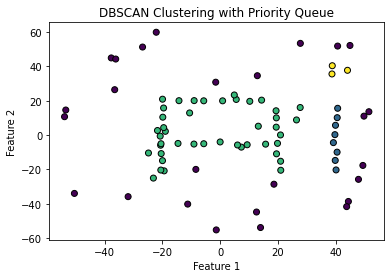

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=dbscan_1.labels_, cmap='viridis', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Priority Queue')
plt.show()

### Problem 6

In [8]:
# Moons Data
X = df2.values
dbscan_2 = DBSCAN(eps=0.3,min_pts=10)
dbscan_2.fit(X)

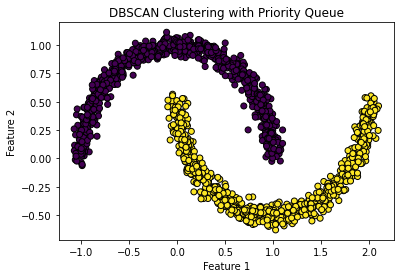

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=dbscan_2.labels_, cmap='viridis', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Priority Queue')
plt.show()

In [10]:
# Circle Data
X = df3.values
dbscan_3 = DBSCAN(eps=0.3,min_pts=10)
dbscan_3.fit(X)

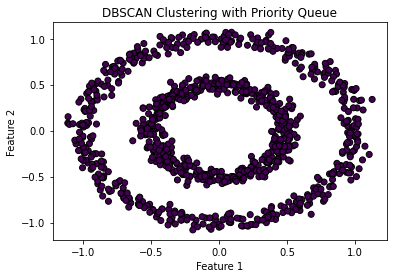

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=dbscan_3.labels_, cmap='viridis', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Priority Queue')
plt.show()

In [12]:
# Blobs Data
X = df4.values
dbscan_4 = DBSCAN(eps=0.3,min_pts=10)
dbscan_4.fit(X)

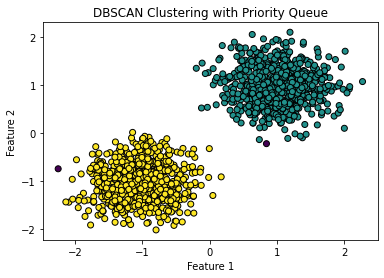

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=dbscan_4.labels_, cmap='viridis', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Priority Queue')
plt.show()

### Problem 7

In [14]:
categories = ['comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'comp.graphics','comp.windows.x' ,'sci.space','sci.electronics']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories ,remove=('headers', 'footers', 'quotes'))

In [15]:
def load_images(file_path):
    with open(file_path, 'rb') as f:
        # Read the magic number and metadata
        magic_number = int.from_bytes(f.read(4), byteorder='big')  # Magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')    # Number of images
        num_rows = int.from_bytes(f.read(4), byteorder='big')      # Rows per image
        num_cols = int.from_bytes(f.read(4), byteorder='big')      # Columns per image

        # Read the image data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)    # Reshape into 3D array
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        # Read the magic number and metadata
        magic_number = int.from_bytes(f.read(4), byteorder='big')  # Magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')    # Number of labels

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


train_images_file = 'Fashion_Mnist/train-images-idx3-ubyte'
train_labels_file = 'Fashion_Mnist/train-labels-idx1-ubyte'
test_images_file = 'Fashion_Mnist/t10k-images-idx3-ubyte'
test_labels_file = 'Fashion_Mnist/t10k-labels-idx1-ubyte'

fashion_mnist_train_images = load_images(train_images_file)
fashion_mnist_train_labels = load_labels(train_labels_file)
fashion_mnist_test_images = load_images(test_images_file)
fashion_mnist_test_labels = load_labels(test_labels_file)


print(f"Number of images: {fashion_mnist_train_images.shape[0]}")
print(f"Image shape: {fashion_mnist_test_images.shape[0:]}")  # Rows x Columns
print(f"Image shape: {fashion_mnist_train_images.shape[1:]}")  # Rows x Columns
print(f"First label: {fashion_mnist_train_labels[0]}")

Number of images: 60000
Image shape: (10000, 28, 28)
Image shape: (28, 28)
First label: 9


In [16]:
# For mnist dataset
def zero_mean_unit_variance_normalization(data):

    mnist_data_normalized_with_unit_var = []
    for image in data:
        image = np.reshape(image,(784,))
        pixel_value_mean = image.mean()
        pixel_value_std = image.std()
        # Shifting scale to [0,1]
        image = (image-pixel_value_mean)/(pixel_value_std)
        mnist_data_normalized_with_unit_var.append(image)
    return mnist_data_normalized_with_unit_var

fashion_mnist_train_images_normalized_with_unit_var = zero_mean_unit_variance_normalization(fashion_mnist_train_images)
fashion_mnist_test_images_normalized_with_unit_var = zero_mean_unit_variance_normalization(fashion_mnist_test_images)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,token_pattern='[A-Za-z]+',use_idf=False)  # Remove stopwords and apply TF-IDF
ng_group_tf_vector = vectorizer.fit_transform(newsgroups_data.data)

In [18]:
household_df = pd.read_csv('HW_2B_Data/household_power_consumption.txt',sep=';')
household_df

/tmp/ipykernel_6289/3976719407.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  household_df = pd.read_csv('HW_2B_Data/household_power_consumption.txt',sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [19]:
household_df.replace('?',0.0,inplace=True)
household_df.dropna(inplace=True)

In [20]:
columns = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']

In [21]:
household_df=household_df[columns].astype('float')

In [36]:
def get_labels_without_noise(data,org_labels,name='xyz'):
    
    if name=='20_ng':
        label = []
        X = []
        for i in range(data.shape[0]):
            if org_labels[i]!=-1:
                label.append(org_labels[i])
                X.append(i)
    else:
        
        label = []
        X = []
        for i in range(data.shape[0]):
            if org_labels[i]!=-1:
                label.append(org_labels[i])
                X.append(data[i])
    
    return X,label

In [68]:
# Faishon MNIST
param_dict = {
                'eps':[8,8.5,9],
                'min_pts':[10,15,20]
             }
faishon_mnist_X = np.array(fashion_mnist_train_images_normalized_with_unit_var[:10000])

for i in range(3):
    eps = param_dict['eps'][i]
    min_pts = param_dict['min_pts'][i]
    faishon_mnist_dbscan = DBSCAN(eps=eps,min_pts=min_pts,batch_size=500)
    faishon_mnist_dbscan.fit(faishon_mnist_X)
    X,label = get_labels_without_noise(faishon_mnist_X,faishon_mnist_dbscan.labels_)
    print(f"\n eps: {eps} \n min_pts:{min_pts}")
    print("No. of unique clusters: ",len(set(label)))
    sil_score=silhouette_score(X,label)
    print(f"\nSilhouette Score: ",sil_score)


 eps: 8 
 min_pts:10
No. of unique clusters:  11

Silhouette Score:  0.13449088379914806

 eps: 8.5 
 min_pts:15
No. of unique clusters:  9

Silhouette Score:  0.17354537451698837

 eps: 9 
 min_pts:20
No. of unique clusters:  6

Silhouette Score:  0.24505997562084222


Here in Faishon MNIST the images are very similar to each other hence the distance will be less between two images hence we need to consider high min_pts and also the distance between two images will be high hence eps should also be selected in that sence

In [46]:
#Household Dataset

param_dict = {
                'eps':[1.5,2,2.5],
                'min_pts':[11,12,13]
             }

household_X = np.array(household_df[:10000])

for i in range(3):
    eps = param_dict['eps'][i]
    min_pts = param_dict['min_pts'][i]
    household_dbscan = DBSCAN(eps=eps,min_pts=min_pts,batch_size=500)
    household_dbscan.fit(household_X)
    X,label = get_labels_without_noise(household_X,household_dbscan.labels_)
    print(f"\neps: {eps} \nmin_pts:{min_pts}")
    print("No. of unique clusters: ",len(set(label)))
    sil_score=silhouette_score(X,label)
    print(f"Silhouette Score: ",sil_score)


eps: 1.5 
min_pts:11
No. of unique clusters:  10
Silhouette Score:  0.6883056079882984

eps: 2 
min_pts:12
No. of unique clusters:  11
Silhouette Score:  0.6812139666424833

eps: 2.5 
min_pts:13
No. of unique clusters:  9
Silhouette Score:  0.6840591731799198


In household dataset eps must be less, if we select large than we will get more points in one cluster hence the no of clusters will decrease and min_pts should be higher as there are lot on points that may be similar.

In [45]:
# 20 NG Dataset
ng_20_X = ng_group_tf_vector
ng_20_dbscan = DBSCAN(eps=0.2,min_pts=2,metric='cosine',batch_size=500)
ng_20_dbscan.fit(ng_20_X)
indices,label = get_labels_without_noise(ng_20_X,ng_20_dbscan.labels_,name='20_ng')
print(f"\neps: {eps} \nmin_pts:{min_pts}")
print("No. of unique clusters: ",len(set(label)))
sil_score=silhouette_score(ng_20_X[indices],label)
print(f"Silhouette Score: ",sil_score)


eps: 0.2 
min_pts:2
No. of unique clusters:  3
Silhouette Score:  0.010105879093780698


I cannot comment on 20 NG as we have considered subset but if we increase the min_pts than there will no core point hence here min_pts should be less and similarity score should also be less so, we can get some core points.